In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import json

from sklearn.model_selection import (
    train_test_split, cross_val_score, ShuffleSplit, GridSearchCV)
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA

from xgboost import XGBRegressor

In [2]:
df = pd.read_csv('/home/akeemlag/Downloads/car_price_prediction.csv')

## EXPLORATORY ANALYSIS

In [3]:
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [4]:
print(df.shape)
df.info()

(19237, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-

In [5]:
df.describe()

,ID,Price,Prod. year,Cylinders,Airbags
count,1.923700e+04,1.923700e+04,19237.000000,19237.000000,19237.000000
mean,4.557654e+07,1.855593e+04,2010.912824,4.582991,6.582627
std,9.365914e+05,1.905813e+05,5.668673,1.199933,4.320168
min,2.074688e+07,1.000000e+00,1939.000000,1.000000,0.000000
25%,4.569837e+07,5.331000e+03,2009.000000,4.000000,4.000000
50%,4.577231e+07,1.317200e+04,2012.000000,4.000000,6.000000
75%,4.580204e+07,2.207500e+04,2015.000000,4.000000,12.000000
max,4.581665e+07,2.630750e+07,2020.000000,16.000000,16.000000


In [6]:
df.duplicated().sum()

313

In [7]:
df.columns = df.columns.str.replace(' ', '_')

df.head()

,ID,Price,Levy,Manufacturer,Model,Prod._year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [8]:
df.nunique()

ID                  18924
Price                2315
Levy                  559
Manufacturer           65
Model                1590
Prod._year             54
Category               11
Leather_interior        2
Fuel_type               7
Engine_volume         107
Mileage              7687
Cylinders              13
Gear_box_type           4
Drive_wheels            3
Doors                   3
Wheel                   2
Color                  16
Airbags                17
dtype: int64

""" There roughly 6000 rows with this kind of data that are not int and not null
If we remove such humongous dataset, it will impact our ds training
Proposition is to conver the remaining value to an int, calculate the mean per year and replace the 
the - with the mean
"""

In [9]:
def isInt(x):
    try:
        int(x)
    except:
        return None
    return int(x)

In [10]:
df.Mileage = df.Mileage.apply(lambda x: x.split(' ')[0])

In [11]:
# Convert Levy to int
cols_to_convert = ['Levy', 'Mileage', 'Cylinders']
for col in cols_to_convert:
    print('current col: ', col)
    df[col] = df[col].apply(isInt)
    if df[col].isna().sum() > 0:
        df[col] = df[col].fillna(df[col].median())
    df[col] = df[col].astype(int)


current col:  Levy
current col:  Mileage
current col:  Cylinders


In [12]:
def create_turbo_col(x):
    try:
        if len(x.split(' '))>1:
            return x[1]
        else:
            return 'Not Turbo'
    except ValueError:
        return 0

In [13]:
# df['Turbo_engine'] = df.Engine_volume.apply(create_turbo_col)

In [14]:
df.Engine_volume = df.Engine_volume.str.split(' ').str[0]
df.Engine_volume = df.Engine_volume.astype(float)

In [15]:
df.describe()

,ID,Price,Levy,Prod._year,Engine_volume,Mileage,Cylinders,Airbags
count,1.923700e+04,1.923700e+04,19237.000000,19237.000000,19237.000000,1.923700e+04,19237.000000,19237.000000
mean,4.557654e+07,1.855593e+04,868.773353,2010.912824,2.307990,1.532236e+06,4.582991,6.582627
std,9.365914e+05,1.905813e+05,390.040440,5.668673,0.877805,4.840387e+07,1.199933,4.320168
min,2.074688e+07,1.000000e+00,87.000000,1939.000000,0.000000,0.000000e+00,1.000000,0.000000
25%,4.569837e+07,5.331000e+03,730.000000,2009.000000,1.800000,7.013900e+04,4.000000,4.000000
50%,4.577231e+07,1.317200e+04,781.000000,2012.000000,2.000000,1.260000e+05,4.000000,6.000000
75%,4.580204e+07,2.207500e+04,917.000000,2015.000000,2.500000,1.888880e+05,4.000000,12.000000
max,4.581665e+07,2.630750e+07,11714.000000,2020.000000,20.000000,2.147484e+09,16.000000,16.000000


## ::: Visualization and Analysis

In [16]:
# Check if any cols contain values that are non int in the numerical cols
numerical_cols = df.select_dtypes(include=['int', 'float']).columns
print('numerical_cols: ', numerical_cols)
categorical_cols = df.select_dtypes(include=['object']).columns
print('categorical_cols: ',categorical_cols)

numerical_cols:  Index(['ID', 'Price', 'Levy', 'Prod._year', 'Engine_volume', 'Mileage',
       'Cylinders', 'Airbags'],
      dtype='object')
categorical_cols:  Index(['Manufacturer', 'Model', 'Category', 'Leather_interior', 'Fuel_type',
       'Gear_box_type', 'Drive_wheels', 'Doors', 'Wheel', 'Color'],
      dtype='object')


#### Categorical features visualization for understanding

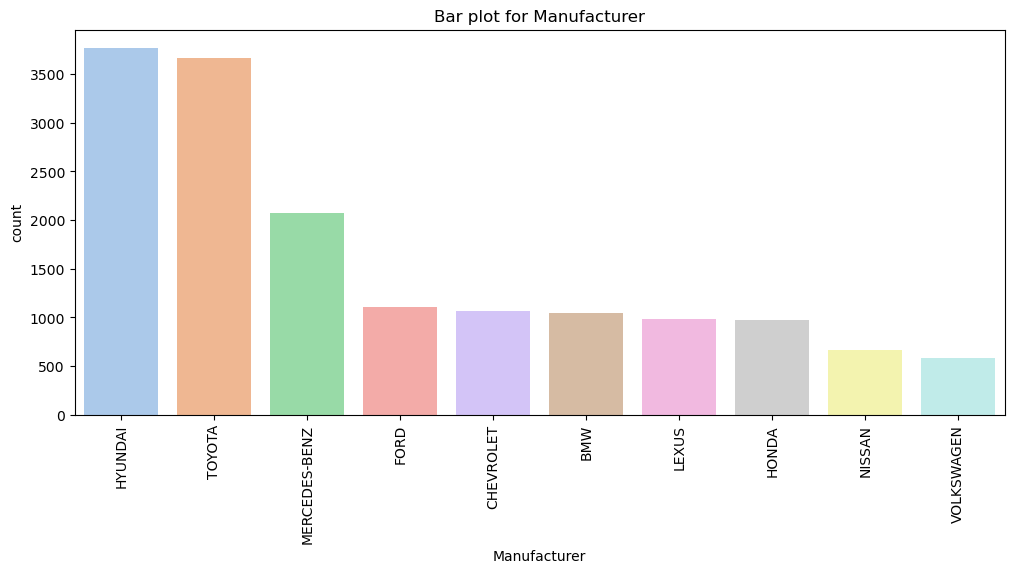

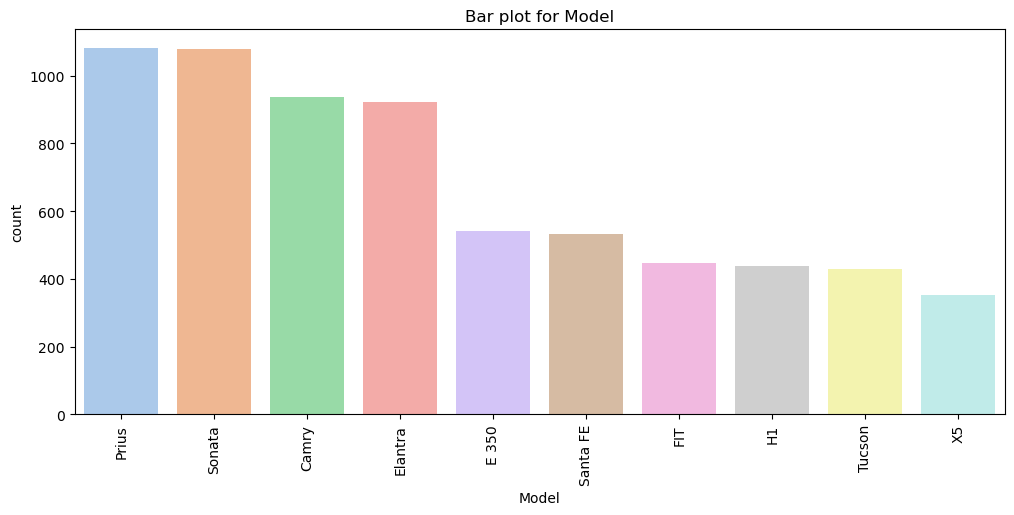

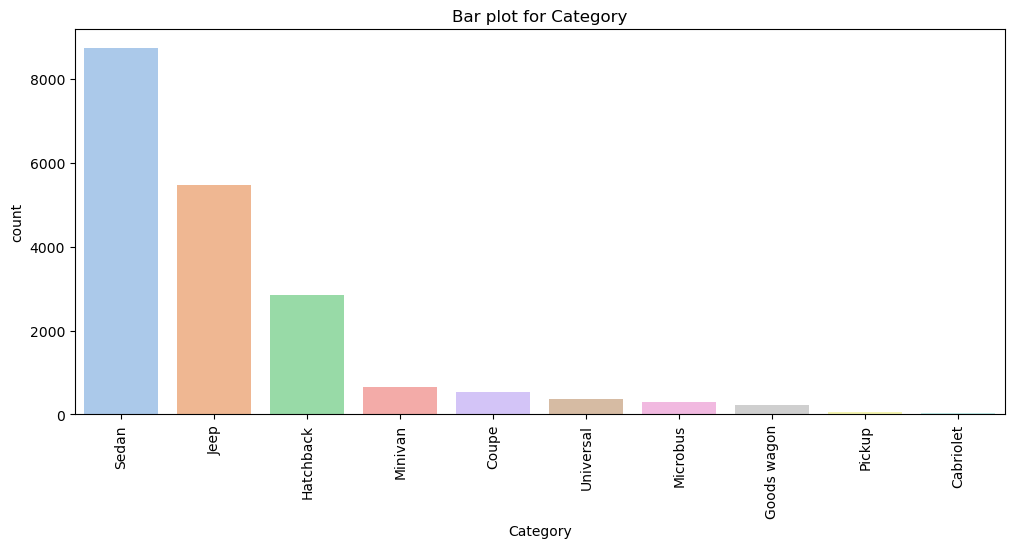

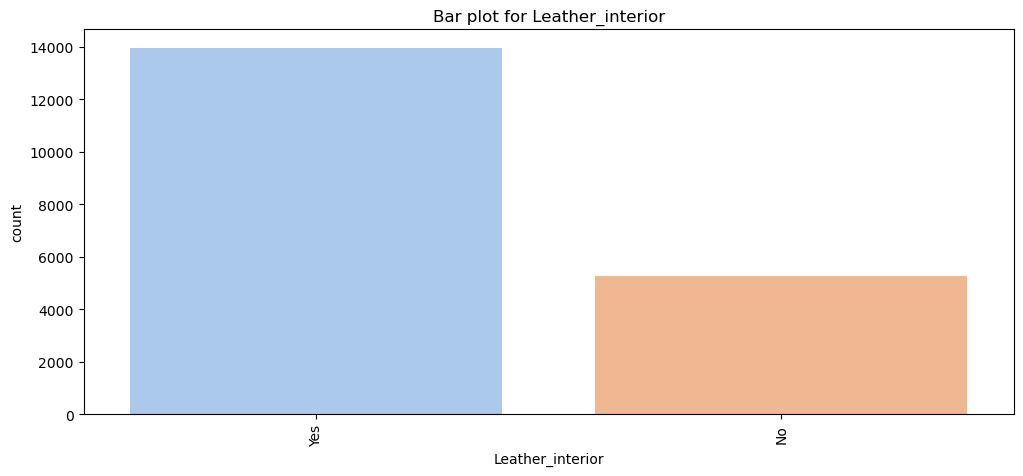

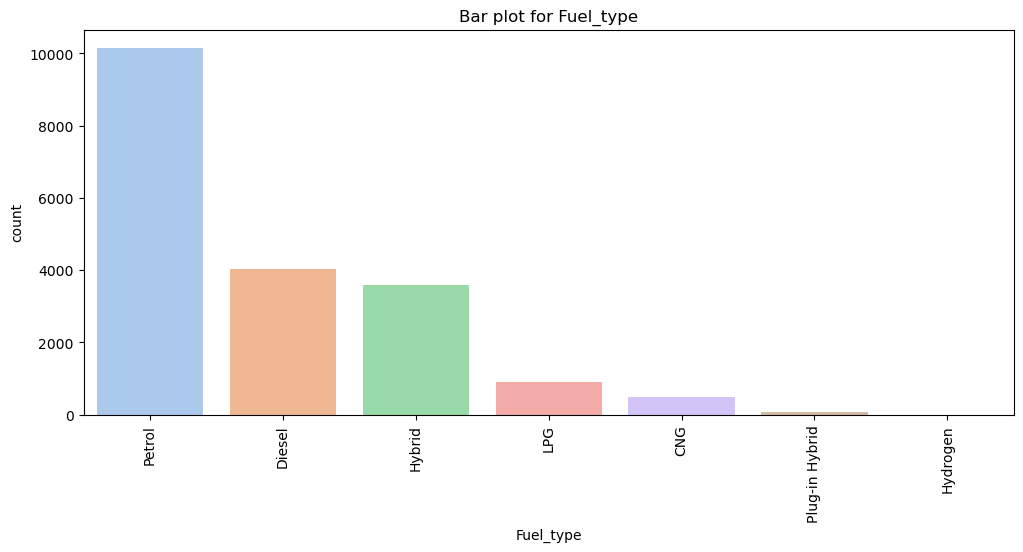

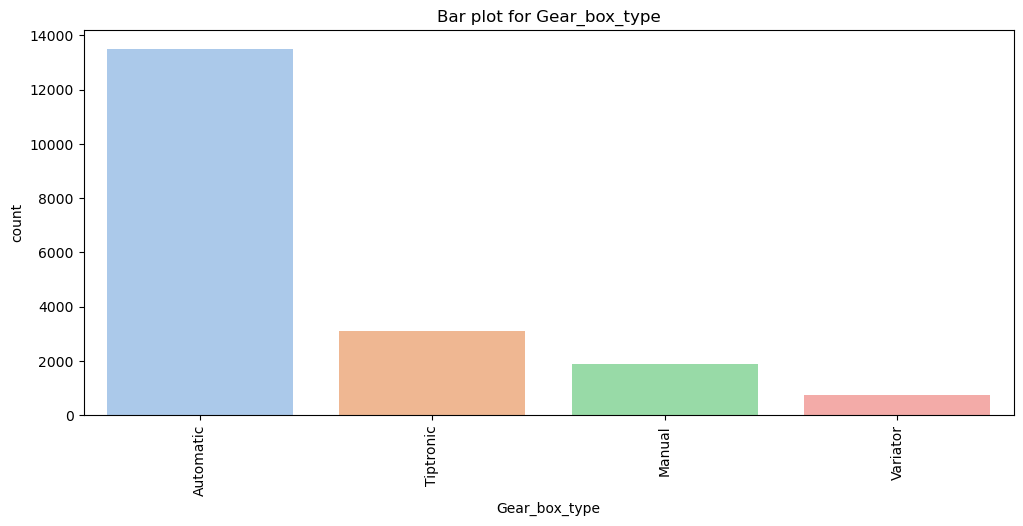

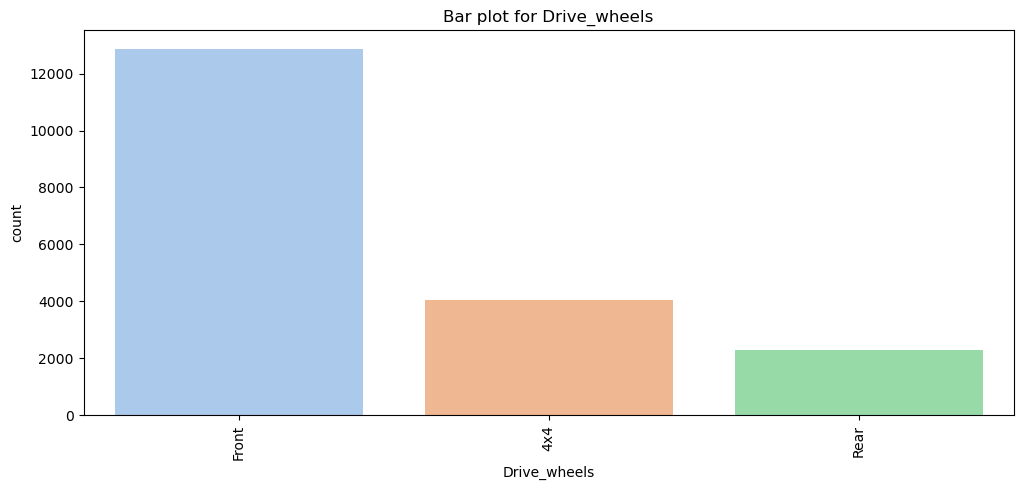

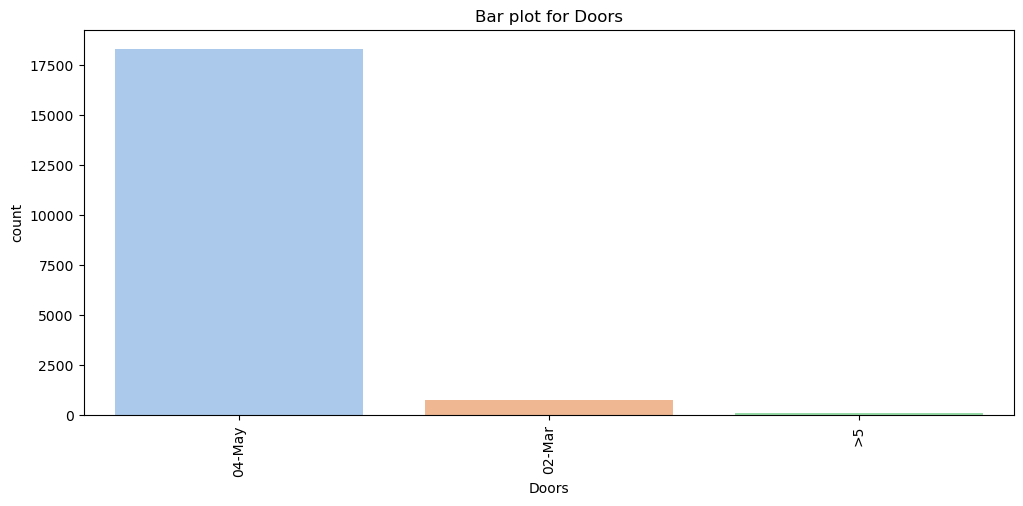

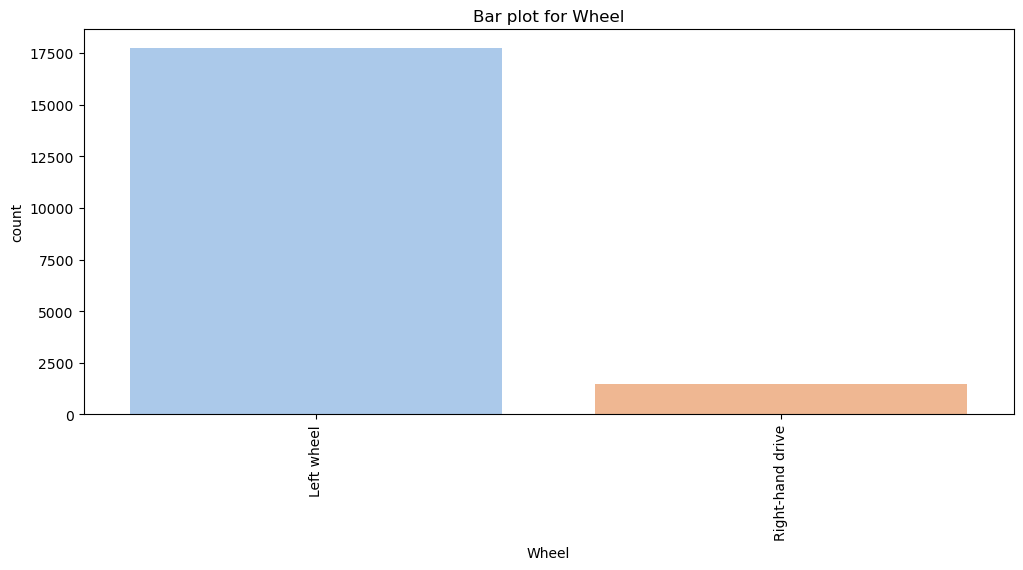

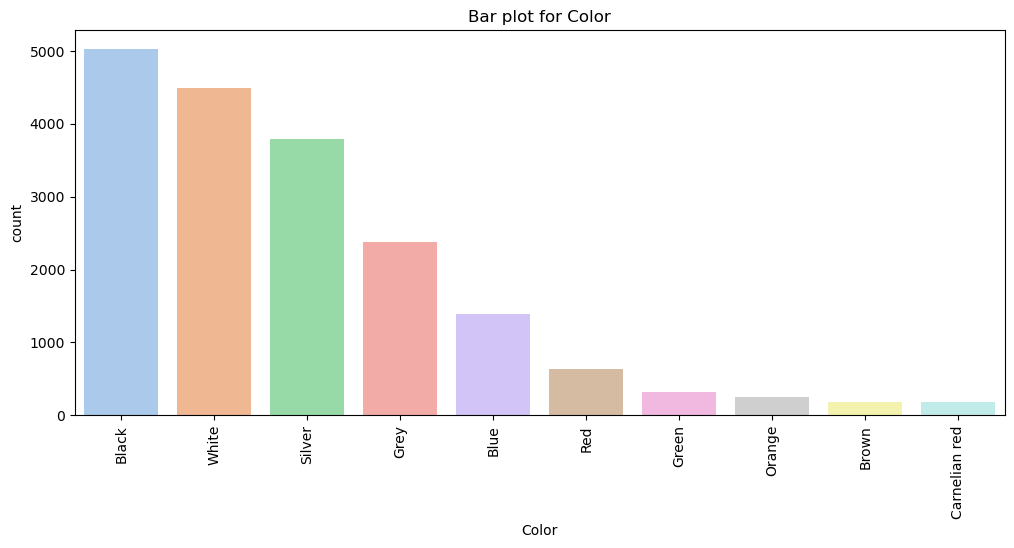

In [17]:
# create a function to draw a barplot for all categorical features
def plot_cat_barplot():
    for cols in categorical_cols:
        plt.figure(figsize=(12,5))
        value = df[cols].value_counts().reset_index()[:10]
        sns.barplot(x=cols, y='count', data=value, hue=cols, palette='pastel')
        plt.xticks(rotation=90)
        plt.title(f'Bar plot for {cols}')
    
plot_cat_barplot()

Analysis if there is a relationship between some categorical features and prices e.g Leather interior

Text(0.5, 1.0, 'Average Price by Leather Interior')

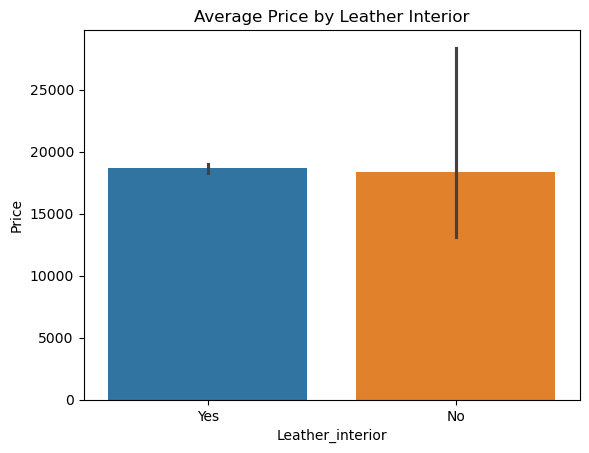

In [28]:
sns.barplot(x='Leather_interior', y='Price', data=df, estimator=np.mean, hue='Leather_interior')
plt.title('Average Price by Leather Interior')

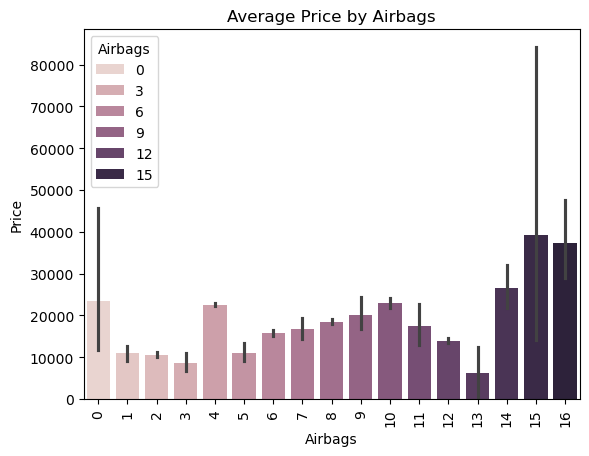

In [30]:
sns.barplot(x='Airbags', y='Price', data=df, estimator=np.mean, hue='Airbags')
plt.title('Average Price by Airbags')
plt.xticks(rotation=90);

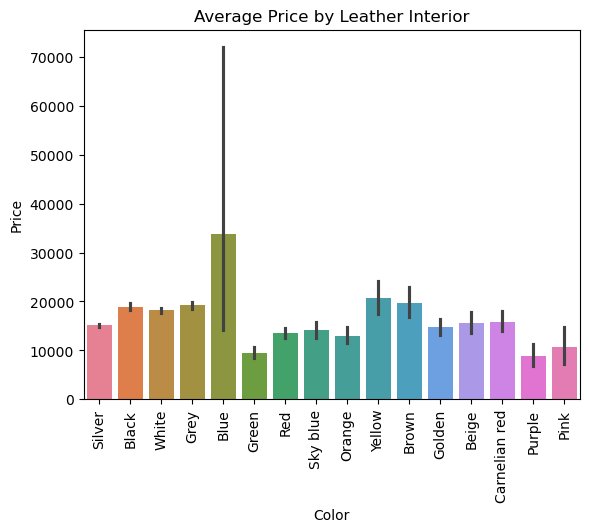

In [25]:

sns.barplot(x='Color', y='Price', data=df, estimator=np.mean, hue='Color')
plt.title('Average Price by Color')
plt.xticks(rotation=90);

Let's create a corr heatmap to see features that are closely related 
Features with a 0.8 corr will dropped in place of that which does not 
have an outlier

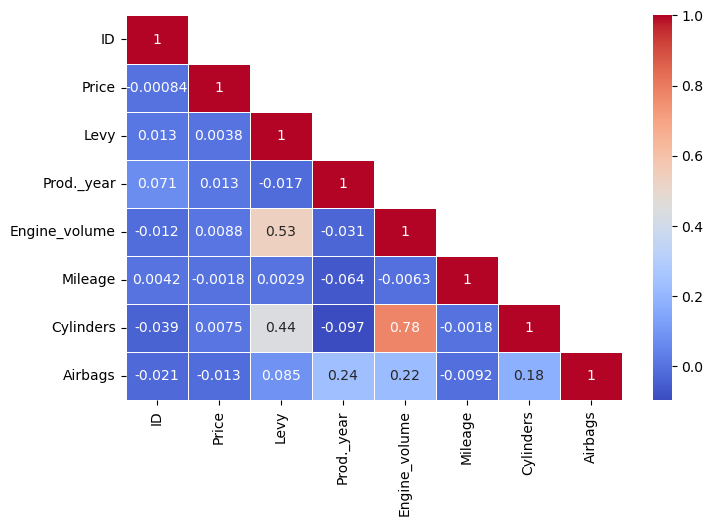

In [29]:
# Corr between numerical cols
corr = df[numerical_cols].corr()
# Remove repetition
plt.figure(figsize=(8,5))
mask = ~np.tri(corr.shape[0], k=0, dtype=bool)

sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5);

#### ::: From observation: Drop some features that serve no purpose

In [393]:
# Drop features that offer no trend or of no significant importance
# Not dropping engine vol or turbo_engine because this is a used car and it most business settings, that affects its resale value
# Drop the ID col and Doors cols ::: ID cols offers no value or trend, Doors col  is populated with the wrong data
cols_to_drop = ['ID', 'Category', 'Doors', 'Color', 'Wheel', 'Drive_wheels', 'Engine_volume', 'Airbags']
df = df.drop(cols_to_drop, axis=1)
df

,Price,Levy,Manufacturer,Model,Prod._year,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Airbags
0,13328,1399,LEXUS,RX 450,2010,Yes,Hybrid,3.5,186005,6,Automatic,12
1,16621,1018,CHEVROLET,Equinox,2011,No,Petrol,3.0,192000,6,Tiptronic,8
2,8467,906,HONDA,FIT,2006,No,Petrol,1.3,200000,4,Variator,2
3,3607,862,FORD,Escape,2011,Yes,Hybrid,2.5,168966,4,Automatic,0
4,11726,446,HONDA,FIT,2014,Yes,Petrol,1.3,91901,4,Automatic,4
...,...,...,...,...,...,...,...,...,...,...,...,...
19232,8467,906,MERCEDES-BENZ,CLK 200,1999,Yes,CNG,2.0,300000,4,Manual,5
19233,15681,831,HYUNDAI,Sonata,2011,Yes,Petrol,2.4,161600,4,Tiptronic,8
19234,26108,836,HYUNDAI,Tucson,2010,Yes,Diesel,2.0,116365,4,Automatic,4
19235,5331,1288,CHEVROLET,Captiva,2007,Yes,Diesel,2.0,51258,4,Automatic,4


#### Let's handle outliers

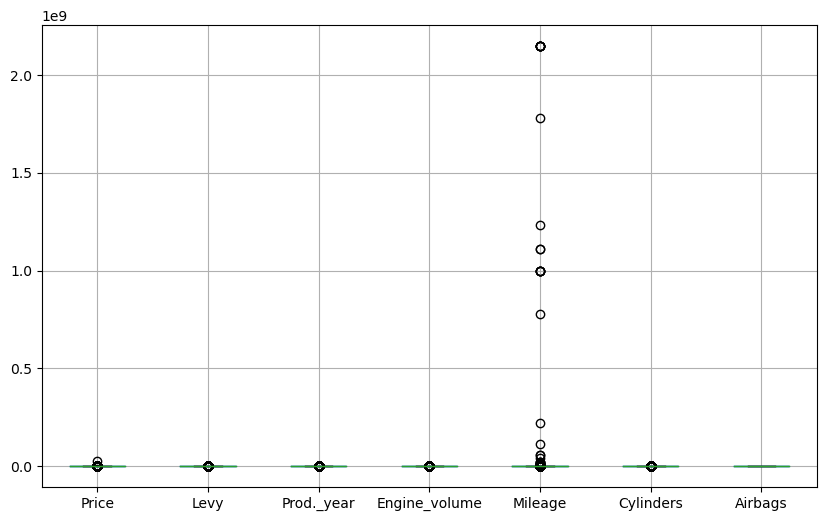

In [394]:
#Create a boc plot to visualize outliers in the numerical cols
numerical_data = df.select_dtypes(exclude=object)
numerical_data
cols = [col for col in numerical_data]
numerical_data.boxplot(figsize=(10,6), column=cols);


In [395]:
# Use quantile to remove outliers in our pricing
def get_and_remove_outliers(col, df):
    min_threshold, max_threshold = df[col].quantile([0.1, 0.9])
    
    print(f'upper_limit: ', {max_threshold})
    print(f'lower_limit: ', {min_threshold})
    no_outliers = df[(df[col] < max_threshold) & (df[col] > min_threshold)]

    return no_outliers

In [396]:
df = get_and_remove_outliers(df=df, col='Mileage')

upper_limit:  {265210.0}
lower_limit:  {25061.400000000005}


In [397]:
df = get_and_remove_outliers(df=df, col='Levy')

upper_limit:  {1266.0}
lower_limit:  {552.0}


In [398]:
df = get_and_remove_outliers(df=df, col='Price')

upper_limit:  {39582.500000000015}
lower_limit:  {941.0}


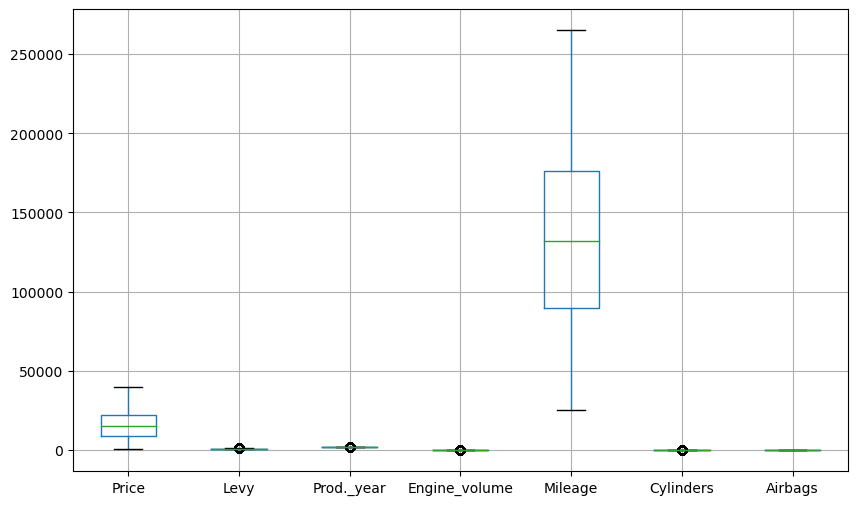

In [399]:
#Create a boc plot to visualize outliers in the numerical cols
numerical_data = df.select_dtypes(exclude=object)
numerical_data
cols = [col for col in numerical_data]
numerical_data.boxplot(figsize=(10,6), column=cols);

In [400]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9807 entries, 1 to 19234
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             9807 non-null   int64  
 1   Levy              9807 non-null   int64  
 2   Manufacturer      9807 non-null   object 
 3   Model             9807 non-null   object 
 4   Prod._year        9807 non-null   int64  
 5   Leather_interior  9807 non-null   object 
 6   Fuel_type         9807 non-null   object 
 7   Engine_volume     9807 non-null   float64
 8   Mileage           9807 non-null   int64  
 9   Cylinders         9807 non-null   int64  
 10  Gear_box_type     9807 non-null   object 
 11  Airbags           9807 non-null   int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 996.0+ KB


In [401]:
# Trim Manufacturer that appers once
man_counts = df['Model'].value_counts()
df = df[df.Model.isin(man_counts[man_counts >= 5].index)]
df

,Price,Levy,Manufacturer,Model,Prod._year,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Airbags
1,16621,1018,CHEVROLET,Equinox,2011,No,Petrol,3.0,192000,6,Tiptronic,8
2,8467,906,HONDA,FIT,2006,No,Petrol,1.3,200000,4,Variator,2
3,3607,862,FORD,Escape,2011,Yes,Hybrid,2.5,168966,4,Automatic,0
5,39493,891,HYUNDAI,Santa FE,2016,Yes,Diesel,2.0,160931,4,Automatic,4
6,1803,761,TOYOTA,Prius,2010,Yes,Hybrid,1.8,258909,4,Automatic,12
...,...,...,...,...,...,...,...,...,...,...,...,...
19226,7840,906,NISSAN,Skyline,2003,Yes,Petrol,3.0,220000,6,Tiptronic,0
19227,29793,1053,MERCEDES-BENZ,E 350,2014,Yes,Diesel,3.5,219030,6,Automatic,12
19231,5802,1055,MERCEDES-BENZ,E 350,2013,Yes,Diesel,3.5,107800,6,Automatic,12
19233,15681,831,HYUNDAI,Sonata,2011,Yes,Petrol,2.4,161600,4,Tiptronic,8


In [402]:
df.groupby(["Model"])['Model'].value_counts().reset_index().sort_values(by='count', ascending=True)

,Model,count
262,Ramcharger,3
264,Renegade,3
4,206,3
333,xD,3
7,225,3
...,...,...
176,H1,331
283,Sonata,446
86,Camry,487
248,Prius,593


In [403]:
models = df.groupby('Manufacturer')['Model'].unique().apply(list)
models_list = models['TOYOTA']
models_list

['Prius',
 'Camry',
 'Aqua',
 'VOXY',
 'Vitz',
 'Yaris',
 'RAV 4',
 'Ist',
 'Corolla',
 'Camry SE',
 'Prius C',
 'Highlander',
 'Ipsum',
 'Passo',
 'Prius V',
 'CHR',
 'Camry se',
 'Corolla LE',
 'Sienna',
 'ISIS',
 'Venza',
 'Corolla S',
 'Tacoma',
 'Land Cruiser Prado',
 'Altezza',
 'Camry SPORT',
 'Hilux',
 'Camry sport',
 'Camry XLE',
 'Wish',
 'Vitz RS',
 'Fun Cargo',
 'Celica',
 '4Runner',
 'Avalon',
 'Camry HYBRID',
 'Land Cruiser']

In [404]:
model_counts = df['Model'].value_counts()

# Filter out Models that appear less than 10 times
cleaned_df = df[df['Model'].isin(model_counts[model_counts >= 5].index)]
cleaned_df

,Price,Levy,Manufacturer,Model,Prod._year,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Airbags
1,16621,1018,CHEVROLET,Equinox,2011,No,Petrol,3.0,192000,6,Tiptronic,8
2,8467,906,HONDA,FIT,2006,No,Petrol,1.3,200000,4,Variator,2
3,3607,862,FORD,Escape,2011,Yes,Hybrid,2.5,168966,4,Automatic,0
5,39493,891,HYUNDAI,Santa FE,2016,Yes,Diesel,2.0,160931,4,Automatic,4
6,1803,761,TOYOTA,Prius,2010,Yes,Hybrid,1.8,258909,4,Automatic,12
...,...,...,...,...,...,...,...,...,...,...,...,...
19226,7840,906,NISSAN,Skyline,2003,Yes,Petrol,3.0,220000,6,Tiptronic,0
19227,29793,1053,MERCEDES-BENZ,E 350,2014,Yes,Diesel,3.5,219030,6,Automatic,12
19231,5802,1055,MERCEDES-BENZ,E 350,2013,Yes,Diesel,3.5,107800,6,Automatic,12
19233,15681,831,HYUNDAI,Sonata,2011,Yes,Petrol,2.4,161600,4,Tiptronic,8


In [405]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8910 entries, 1 to 19234
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             8910 non-null   int64  
 1   Levy              8910 non-null   int64  
 2   Manufacturer      8910 non-null   object 
 3   Model             8910 non-null   object 
 4   Prod._year        8910 non-null   int64  
 5   Leather_interior  8910 non-null   object 
 6   Fuel_type         8910 non-null   object 
 7   Engine_volume     8910 non-null   float64
 8   Mileage           8910 non-null   int64  
 9   Cylinders         8910 non-null   int64  
 10  Gear_box_type     8910 non-null   object 
 11  Airbags           8910 non-null   int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 904.9+ KB


In [406]:
# for col in categorical_cols:
#     plt.figure(figsize=(20,10))
#     sns.countplot(data=df, x=col, hue=col, palette='pastel')
#     plt.title(f'Count plot of {col}')
#     plt.xlabel(col)
#     plt.ylabel('Count')
#     plt.xticks(rotation=45);

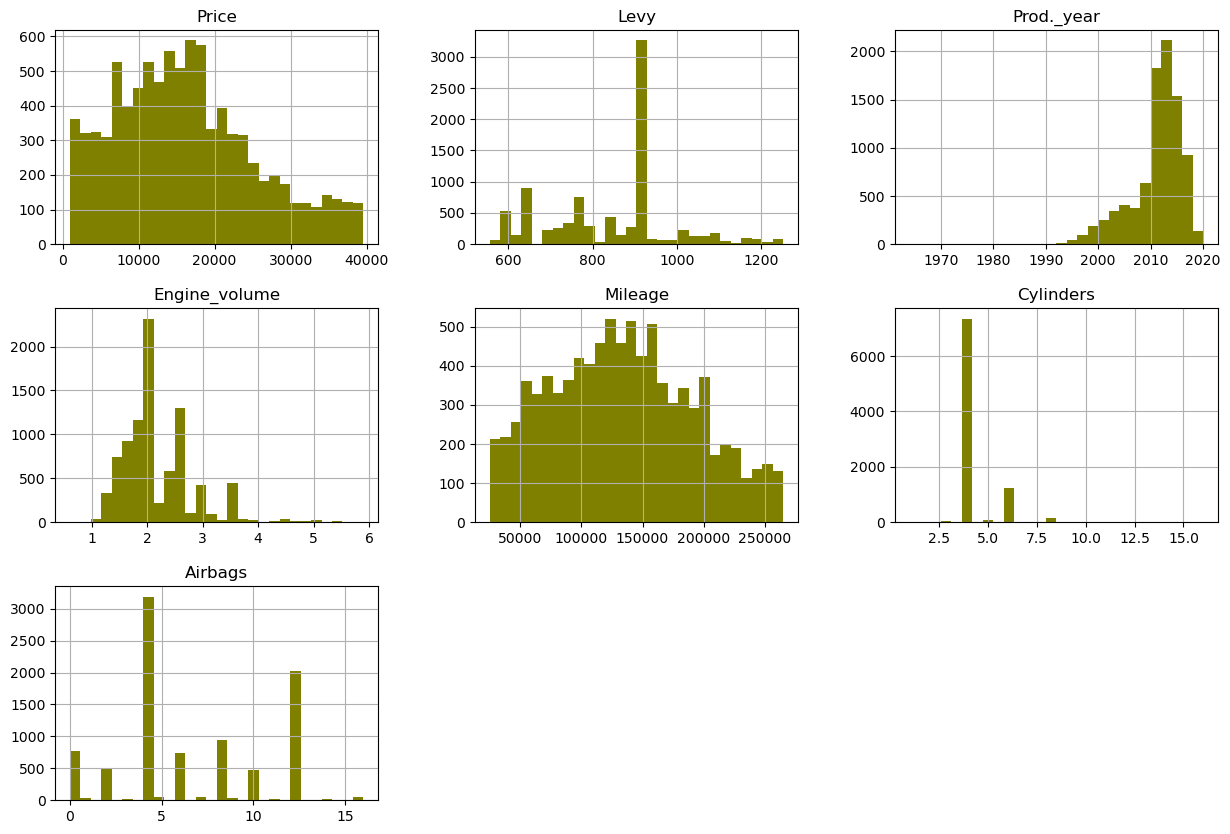

In [407]:
df.hist(bins = 28, figsize=(15, 10), color ='olive');

In [408]:
df.columns

Index(['Price', 'Levy', 'Manufacturer', 'Model', 'Prod._year',
       'Leather_interior', 'Fuel_type', 'Engine_volume', 'Mileage',
       'Cylinders', 'Gear_box_type', 'Airbags'],
      dtype='object')

In [409]:
"""STANDARDIZATION"""
scaler = StandardScaler()

scaled_data_mileage = scaler.fit_transform(df[['Mileage']])

df.loc[:,'Mileage'] = scaled_data_mileage

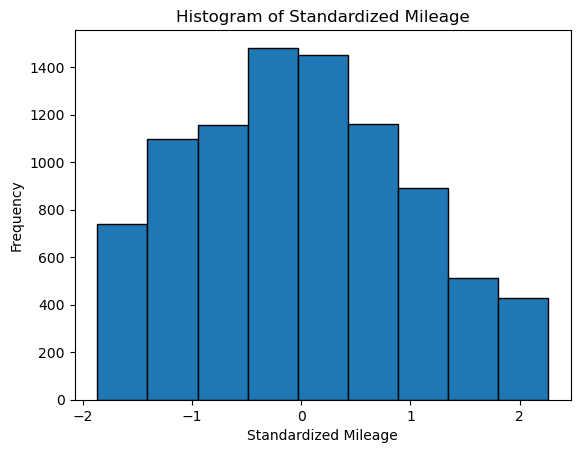

In [410]:
# plot a histogram to showcase the standardized values
plt.hist(df.Mileage, bins=9, edgecolor='black')
plt.xlabel('Standardized Mileage')
plt.ylabel('Frequency')
plt.title('Histogram of Standardized Mileage');

In [411]:
cleaned_df = df.copy()

In [412]:
# Dsplay the Manufacturer, Model against the Category
cat_df = cleaned_df.copy()
cat_df['group'] = cat_df['Manufacturer']
pivot_table = pd.pivot_table(cat_df, columns='Fuel_type', values='Manufacturer', index=['group'], aggfunc='count', fill_value=0)
pivot_table['row_sum'] = pivot_table.sum(axis=1)
pivot_table = pivot_table[['row_sum'] + [col for col in pivot_table.columns if col != 'row_sum']]

pivot_table.sort_values(ascending=False, by='row_sum').head()

Fuel_type,row_sum,CNG,Diesel,Hybrid,Hydrogen,LPG,Petrol,Plug-in Hybrid
group,,,,,,,,
HYUNDAI,2177,0,891,59,1,219,1007,0
TOYOTA,1615,11,11,888,0,21,677,7
MERCEDES-BENZ,695,58,269,0,0,29,339,0
CHEVROLET,585,0,214,0,0,14,340,17
FORD,498,3,134,110,0,1,235,15


In [414]:
dummies_manu = pd.get_dummies(cleaned_df['Manufacturer'], drop_first=True, dtype=int)
dummies_model = pd.get_dummies(cleaned_df['Model'], drop_first=True, dtype=int)
dummies_fuel_type = pd.get_dummies(cleaned_df['Fuel_type'], drop_first=True, dtype=int)
dummies_gear = pd.get_dummies(cleaned_df['Gear_box_type'], drop_first=True, dtype=int)
dummies_leather_int = pd.get_dummies(cleaned_df['Leather_interior'], drop_first=True, dtype=int)
# dummies_turbo_eng = pd.get_dummies(cleaned_df['Turbo_engine'], drop_first=True, dtype=int)

In [415]:
cols_to_encode = ['Manufacturer', 'Model', 'Fuel_type', 'Gear_box_type', 'Leather_interior']
cleaned_df = pd.concat([cleaned_df.drop(columns=cols_to_encode), dummies_manu, dummies_fuel_type, dummies_model, dummies_gear, dummies_leather_int, dummies_turbo_eng], axis=1)

In [416]:
cleaned_df.head()

,Price,Levy,Prod._year,Engine_volume,Mileage,Cylinders,Airbags,AUDI,BMW,BUICK,...,XV,Yaris,Zafira,tC,xD,Manual,Tiptronic,Variator,Yes,Not Turbo
1,16621,1018,2011,3.0,1.005039,6,8,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,8467,906,2006,1.3,1.142694,4,2,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,3607,862,2011,2.5,0.608697,4,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
5,39493,891,2016,2.0,0.470439,4,4,0,0,0,...,0,0,0,0,0,0,0,0,1,1
6,1803,761,2010,1.8,2.156333,4,12,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [ ]:
"""TRAIN TEST SPLIT"""

'TRAIN TEST SPLIT'

In [417]:
X = cleaned_df.drop('Price', axis=1)
y = cleaned_df.Price

In [ ]:
# X_scaled = scaler.fit_transform(X)

In [418]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [422]:
lr_model = LinearRegression(n_jobs=10)
lr_model.fit(X_train, y_train)

LinearRegression(n_jobs=10)

In [423]:
lr_model.score(X_test, y_test)

-184192959147189.5

In [424]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

In [434]:
def get_best_model(X,y):
    model_params = {
        'random_forest_reg': {
            'model': RandomForestRegressor(),
            'params': {
                'max_depth': [10, 20],
                'n_estimators': [100, 150],
                'min_samples_split': [5,10],
                'min_samples_leaf': [1,2,4]
            }
        },
        # 'decission_tree_reg': {
        #     'model': DecisionTreeRegressor(),
        #     'params': {
        #         'criterion': ['poisson', 'friedman_mse'],
        #         'splitter': ['best', 'random']
        #     }
        # },
        # 'xgb_regressor': {
        #     'model': XGBRegressor(objective='reg:squarederror', enable_categorical=True),
        #     'params': {
        #         'n_estimators': [300]
        #     }
        # }
    }
    scores = []
    for model_name, mp in model_params.items():
        gs = GridSearchCV(mp['model'], mp['params'], cv=cv, return_train_score=False)
        gs.fit(X, y)
        scores.append({
            'model_name': model_name,
            'best_params': gs.best_params_,
            'best_score': gs.best_score_
        })
    best_model = pd.DataFrame(scores, columns=['model_name', 'best_params', 'best_score'])
    return best_model

In [435]:
get_best_model(X_train, y_train)

,model_name,best_params,best_score
0,random_forest_reg,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_...",0.78446


In [432]:
def train_test_cross_validate(model, X_train, y_train, X_test, y_test, cv):
    model.fit(X_train, y_train)
    model_score = model.score(X_test, y_test)
    
    # Train pred
    y_train_pred = model.predict(X_train)
    rmse_train = mean_absolute_error(y_train, y_train_pred)

    # Test Pred
    y_test_pred = model.predict(X_test)
    rmse_test = mean_absolute_error(y_test, y_test_pred)

    # Perform 5-fold cross-validation
    rmse_cv = -cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv)

    rmse_cv_mean = np.mean(rmse_cv)

    # Display results
    print(f'Model Score: {model_score:.4f}')
    print(f"Training RMSE: {rmse_train:.4f}")
    print()
    print(f"Initial Test RMSE: {rmse_test:.4f}")
    print()
    print(f"Average Cross-Validation RMSE: {rmse_cv_mean:.4f}")
    print()
    print(f"Cross-Validation Scores: {rmse_cv}\n")
    print()

In [433]:
additional_params = {
    'X_train' : X_train, 
    'y_train' : y_train, 
    'X_test' : X_test, 
    'y_test': y_test, 
    'cv':10}


models = {
    'Xgboost': XGBRegressor(n_estimators=100),
    'Random Forest': RandomForestRegressor(max_depth=10, n_estimators=200),
}

for model_name, model in models.items():
    print(f'{model_name} Regression Model: ')
    print()

    trained_model = train_test_cross_validate(model, **additional_params)

    print(trained_model)

Xgboost Regression Model: 

Model Score: 0.7737
Training RMSE: 2338.1533

Initial Test RMSE: 2989.5086

Average Cross-Validation RMSE: 4432.6925

Cross-Validation Scores: [4594.07144907 4736.48040944 4464.79306557 4311.74973077 4699.9275274
 4115.15644068 4367.91019216 4497.47676391 4214.73459256 4324.62513065]


None
Random Forest Regression Model: 

Model Score: 0.7441
Training RMSE: 2907.4883

Initial Test RMSE: 3318.9672

Average Cross-Validation RMSE: 4756.1987

Cross-Validation Scores: [4927.82174106 5133.15111581 4721.63573694 4528.70789678 4851.98392862
 4405.3938441  5025.10819905 4833.62493534 4588.49642605 4546.06329105]


None
